In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
import xgboost as xgb

# --- Step 1: Data Loading ---
print("Step 1: Loading Data...")
# Load the datasets using their contentFetchIds
try:
    train_df = pd.read_csv("Auto_Insurance_Fraud_Claims_File01.csv")
    test_df = pd.read_csv("Auto_Insurance_Fraud_Claims_File02.csv")
    predict_df = pd.read_csv("Auto_Insurance_Fraud_Claims_File03.csv")
    submission_df = pd.read_csv("Auto_Insurance_Fraud_Claims_Results_Submission.csv")
    print("All CSV files loaded successfully.")
except Exception as e:
    print(f"Error loading CSV files: {e}")
    # Exit or handle the error appropriately if files can't be loaded
    exit()

# --- Step 2: Standardizing Column Names ---
print("\nStep 2: Standardizing Column Names...")
def standardize_column_names(df):
    """Converts column names to lowercase and replaces spaces with underscores."""
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('1', '')
    return df

train_df = standardize_column_names(train_df)
test_df = standardize_column_names(test_df)
predict_df = standardize_column_names(predict_df)
print("Column names standardized for all dataframes.")
print("Sample train_df columns:", train_df.columns.tolist()[:5])

# --- Step 3: Convert Fraud_Ind (Y/N) to numerical (1/0) ---
print("\nStep 3: Converting 'fraud_ind' to numerical (1/0)...")
# Check if 'fraud_ind' column exists before attempting conversion
if 'fraud_ind' in train_df.columns:
    train_df['fraud_ind'] = train_df['fraud_ind'].map({'Y': 1, 'N': 0})
    print("train_df 'fraud_ind' converted.")
else:
    print("Warning: 'fraud_ind' column not found in train_df.")

if 'fraud_ind' in test_df.columns:
    test_df['fraud_ind'] = test_df['fraud_ind'].map({'Y': 1, 'N': 0})
    print("test_df 'fraud_ind' converted.")
else:
    print("Warning: 'fraud_ind' column not found in test_df.")

# Note: predict_df does not have 'fraud_ind' initially, which is expected.

# --- Step 4: Handle Missing Values for specific columns ---
print("\nStep 4: Handling specific missing values...")
# Fill 'authorities_contacted' and 'police_report' missing values
for df in [train_df, test_df, predict_df]:
    if 'authorities_contacted' in df.columns:
        df['authorities_contacted'].fillna('Not Contacted', inplace=True)
    if 'police_report' in df.columns:
        df['police_report'].fillna('No', inplace=True)
print("Missing values in 'authorities_contacted' and 'police_report' filled.")

# --- Step 5: Remove Duplicate Rows ---
print("\nStep 5: Removing duplicate rows...")
initial_train_rows = train_df.shape[0]
initial_test_rows = test_df.shape[0]
initial_predict_rows = predict_df.shape[0]

train_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)
predict_df.drop_duplicates(inplace=True)

print(f"Removed {initial_train_rows - train_df.shape[0]} duplicate rows from train_df.")
print(f"Removed {initial_test_rows - test_df.shape[0]} duplicate rows from test_df.")
print(f"Removed {initial_predict_rows - predict_df.shape[0]} duplicate rows from predict_df.")

print("\nInitial Data Preprocessing Complete.")
print("Train DataFrame Info:")
train_df.info()
print("\nTest DataFrame Info:")
test_df.info()
print("\nPredict DataFrame Info:")
predict_df.info()

# Display first few rows of processed dataframes
print("\nFirst 5 rows of processed train_df:")
print(train_df.head())
print("\nFirst 5 rows of processed test_df:")
print(test_df.head())
print("\nFirst 5 rows of processed predict_df:")
print(predict_df.head())


Step 1: Loading Data...
All CSV files loaded successfully.

Step 2: Standardizing Column Names...
Column names standardized for all dataframes.
Sample train_df columns: ['claim_id', 'bind_date', 'customer_life_value', 'age_insured', 'policy_num']

Step 3: Converting 'fraud_ind' to numerical (1/0)...
train_df 'fraud_ind' converted.
test_df 'fraud_ind' converted.

Step 4: Handling specific missing values...
Missing values in 'authorities_contacted' and 'police_report' filled.

Step 5: Removing duplicate rows...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17844\1850969212.py:62: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['authorities_contacted'].fillna('Not Contacted', inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17844\1850969212.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

Removed 0 duplicate rows from train_df.
Removed 0 duplicate rows from test_df.
Removed 0 duplicate rows from predict_df.

Initial Data Preprocessing Complete.
Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   claim_id                  40000 non-null  object 
 1   bind_date                 40000 non-null  object 
 2   customer_life_value       40000 non-null  int64  
 3   age_insured               40000 non-null  int64  
 4   policy_num                40000 non-null  int64  
 5   policy_state              40000 non-null  object 
 6   policy_start_date         40000 non-null  object 
 7   policy_expiry_date        40000 non-null  object 
 8   policy_bi                 40000 non-null  object 
 9   policy_ded                40000 non-null  int64  
 10  policy_premium            40000 non-null  flo

--- Starting Exploratory Data Analysis (EDA) ---

1. Generating Class Imbalance Plot...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17844\1223709174.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='fraud_ind', data=train_df, palette='viridis')


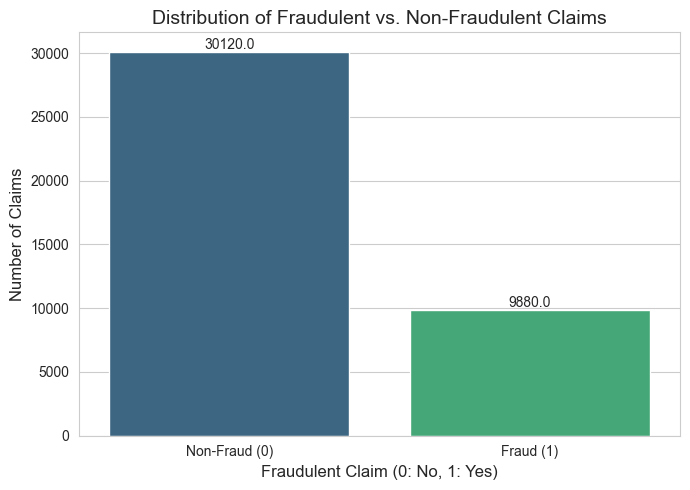

Fraudulent claims make up 24.70% of the training data.
Non-fraudulent claims make up 75.30% of the training data.

2. Generating Fraud Rate by Accident Type Plot...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17844\1223709174.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_accident_type.index, y=fraud_by_accident_type.values, palette='magma')


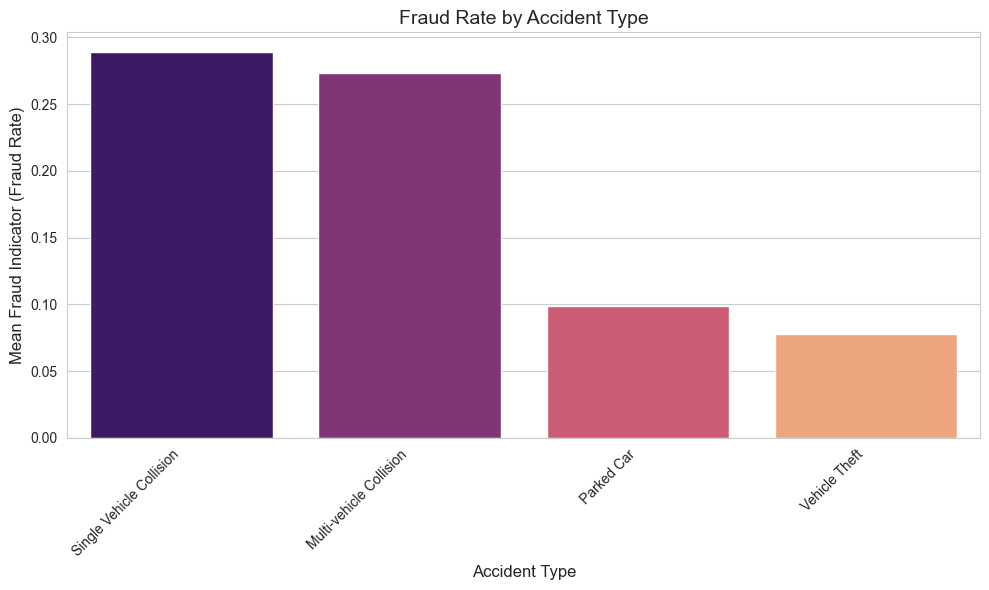


3. Generating Fraud Rate by Accident Severity Plot...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17844\1223709174.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_accident_severity.index, y=fraud_by_accident_severity.values, palette='cividis')


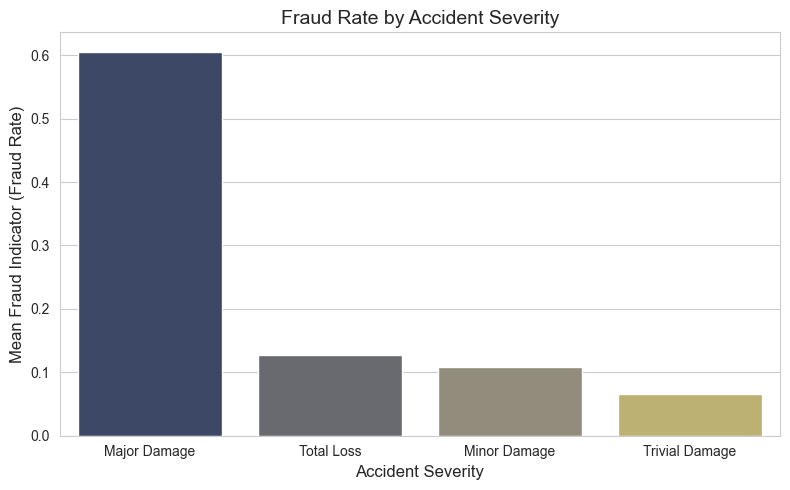


4. Generating Total Claim Distribution Plot by Fraud Status...


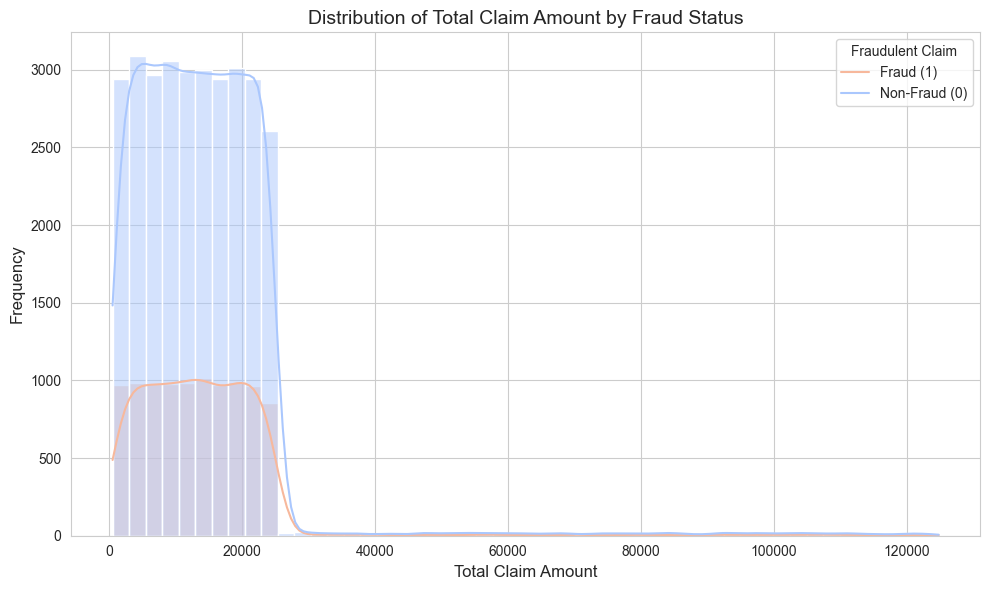


5. Generating Correlation Heatmap for Numerical Features...
Top 10 numerical features correlated with 'fraud_ind':
fraud_ind                   1.000000
umbrella_limit              0.068021
witnesses                   0.057884
num_of_vehicles_involved    0.053345
vehicle_cost                0.032308
bodily_injuries             0.031575
accident_hour               0.022009
age_insured                 0.021899
policy_ded                  0.018128
annual_mileage              0.007354
total_claim                 0.005026
Name: fraud_ind, dtype: float64
Not enough relevant numerical features for a meaningful heatmap (correlation threshold > 0.1).

6. Generating Fraud Proportion by Policy State Plot...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17844\1223709174.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_by_state.index, y=fraud_by_state.values, palette='rocket')


<Figure size 1400x1200 with 0 Axes>

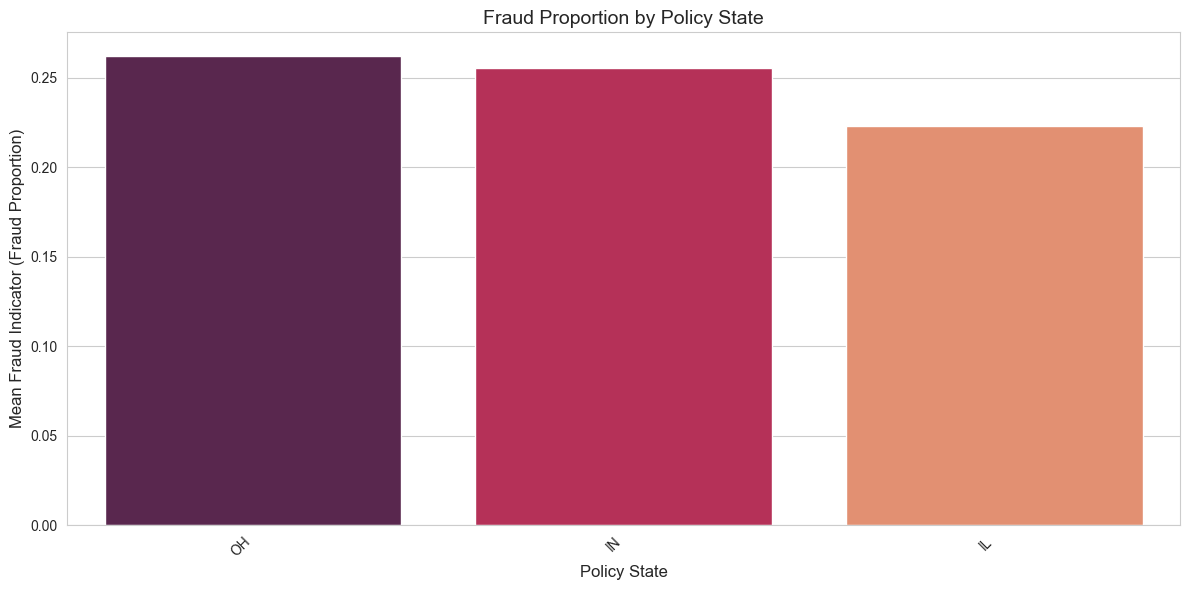


--- EDA Complete. Visualizations generated. ---


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_df is already loaded and preprocessed from the previous step

print("--- Starting Exploratory Data Analysis (EDA) ---")

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100 # Adjust for better resolution if needed

# --- 1. Class Imbalance Plot (Slide 6) ---
print("\n1. Generating Class Imbalance Plot...")
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='fraud_ind', data=train_df, palette='viridis')
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Claims', fontsize=14)
plt.xlabel('Fraudulent Claim (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Number of Claims', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Non-Fraud (0)', 'Fraud (1)'])
# Add counts on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=10)
plt.tight_layout()
plt.show()

fraud_percentage = train_df['fraud_ind'].value_counts(normalize=True) * 100
print(f"Fraudulent claims make up {fraud_percentage[1]:.2f}% of the training data.")
print(f"Non-fraudulent claims make up {fraud_percentage[0]:.2f}% of the training data.")

# --- 2. Accident Characteristics: Fraud Rate by Accident Type (Slide 6) ---
print("\n2. Generating Fraud Rate by Accident Type Plot...")
plt.figure(figsize=(10, 6))
fraud_by_accident_type = train_df.groupby('accident_type')['fraud_ind'].mean().sort_values(ascending=False)
sns.barplot(x=fraud_by_accident_type.index, y=fraud_by_accident_type.values, palette='magma')
plt.title('Fraud Rate by Accident Type', fontsize=14)
plt.xlabel('Accident Type', fontsize=12)
plt.ylabel('Mean Fraud Indicator (Fraud Rate)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# --- 3. Accident Characteristics: Fraud Rate by Accident Severity (Slide 6) ---
print("\n3. Generating Fraud Rate by Accident Severity Plot...")
plt.figure(figsize=(8, 5))
fraud_by_accident_severity = train_df.groupby('accident_severity')['fraud_ind'].mean().sort_values(ascending=False)
sns.barplot(x=fraud_by_accident_severity.index, y=fraud_by_accident_severity.values, palette='cividis')
plt.title('Fraud Rate by Accident Severity', fontsize=14)
plt.xlabel('Accident Severity', fontsize=12)
plt.ylabel('Mean Fraud Indicator (Fraud Rate)', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 4. Claim Amount Patterns: Total Claim Distribution (Slide 6) ---
print("\n4. Generating Total Claim Distribution Plot by Fraud Status...")
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='total_claim', hue='fraud_ind', kde=True, bins=50, palette='coolwarm', common_norm=False)
plt.title('Distribution of Total Claim Amount by Fraud Status', fontsize=14)
plt.xlabel('Total Claim Amount', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Fraudulent Claim', labels=['Fraud (1)', 'Non-Fraud (0)'])
plt.tight_layout()
plt.show()

# --- 5. Feature Relationships: Correlation Heatmap (Slide 6) ---
print("\n5. Generating Correlation Heatmap for Numerical Features...")
# Select only numerical columns for correlation calculation
numerical_cols = train_df.select_dtypes(include=np.number).columns.tolist()
# Exclude 'policy_num' and 'insured_zip' if they are just identifiers and not numerical features
numerical_cols_for_corr = [col for col in numerical_cols if col not in ['policy_num', 'insured_zip']]

plt.figure(figsize=(14, 12))
correlation_matrix = train_df[numerical_cols_for_corr].corr()
# Filter correlations with 'fraud_ind'
fraud_correlations = correlation_matrix['fraud_ind'].sort_values(ascending=False)
# Display top N correlations for brevity if too many
print("Top 10 numerical features correlated with 'fraud_ind':")
print(fraud_correlations.head(11)) # Including fraud_ind itself

# Plot heatmap for a subset of highly correlated features or all if not too many
# For demonstration, let's plot for features with abs correlation > 0.1 with fraud_ind
relevant_features = fraud_correlations[abs(fraud_correlations) > 0.1].index.tolist()
if 'fraud_ind' not in relevant_features: # Ensure fraud_ind is included
    relevant_features.append('fraud_ind')
relevant_features = [f for f in relevant_features if f in numerical_cols_for_corr] # Ensure they are in the original list

if len(relevant_features) > 1:
    sns.heatmap(train_df[relevant_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Heatmap of Relevant Numerical Features', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough relevant numerical features for a meaningful heatmap (correlation threshold > 0.1).")


# --- 6. Geographical Trends: Fraud Proportion by Policy State (Slide 6) ---
print("\n6. Generating Fraud Proportion by Policy State Plot...")
plt.figure(figsize=(12, 6))
fraud_by_state = train_df.groupby('policy_state')['fraud_ind'].mean().sort_values(ascending=False)
sns.barplot(x=fraud_by_state.index, y=fraud_by_state.values, palette='rocket')
plt.title('Fraud Proportion by Policy State', fontsize=14)
plt.xlabel('Policy State', fontsize=12)
plt.ylabel('Mean Fraud Indicator (Fraud Proportion)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n--- EDA Complete. Visualizations generated. ---")


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Assuming train_df, test_df, predict_df are already loaded and preprocessed from previous steps

print("--- Starting Feature Engineering & Preprocessing (Phase 2) ---")

# Combine all dataframes for consistent feature engineering
# We'll separate them again before modeling
all_data = pd.concat([train_df.drop(columns=['fraud_ind']), test_df.drop(columns=['fraud_ind']), predict_df], ignore_index=True)

# Store claim_ids for later use in submission
train_claim_ids = train_df['claim_id']
test_claim_ids = test_df['claim_id']
predict_claim_ids = predict_df['claim_id']

# Drop claim_id, policy_num, insured_zip, vehicle_registration, check_point as they are identifiers or not directly useful features
# 'check_point' seems to be a redundant column from the dataset structure, often 'No'
cols_to_drop = ['claim_id', 'policy_num', 'insured_zip', 'vehicle_registration', 'check_point']
all_data = all_data.drop(columns=[col for col in cols_to_drop if col in all_data.columns])


# --- 1. Date Features ---
print("\n1. Extracting Date Features...")
date_cols = ['bind_date', 'policy_start_date', 'policy_expiry_date', 'accident_date', 'dl_expiry_date', 'claims_date']
for col in date_cols:
    # Convert to datetime, handling potential errors
    all_data[col] = pd.to_datetime(all_data[col], errors='coerce')

    # Extract year, month, day, day of week
    all_data[f'{col}_year'] = all_data[col].dt.year
    all_data[f'{col}_month'] = all_data[col].dt.month
    all_data[f'{col}_day'] = all_data[col].dt.day
    all_data[f'{col}_dayofweek'] = all_data[col].dt.dayofweek

# --- 2. Duration/Age Features ---
print("\n2. Calculating Duration/Age Features...")
# Policy Duration in Days
all_data['policy_duration_days'] = (all_data['policy_expiry_date'] - all_data['policy_start_date']).dt.days

# Claim Lag Days (Accident Date - Policy Start Date)
all_data['claim_lag_days'] = (all_data['accident_date'] - all_data['policy_start_date']).dt.days

# Vehicle Age at Accident (Accident Year - Auto Year)
all_data['vehicle_age_at_accident'] = all_data['accident_date_year'] - all_data['auto_year']
# Handle cases where vehicle_age_at_accident might be negative (e.g., accident in same year as car model year, or data error)
all_data['vehicle_age_at_accident'] = all_data['vehicle_age_at_accident'].apply(lambda x: max(0, x))


# --- 3. Policy_BI Split ---
print("\n3. Splitting 'policy_bi' into two numerical columns...")
# Fill any NaN values that might arise from previous steps before splitting
all_data['policy_bi'] = all_data['policy_bi'].astype(str).str.replace(' ', '')
all_data[['policy_bi_per_person', 'policy_bi_per_accident']] = all_data['policy_bi'].str.split('/', expand=True)
all_data['policy_bi_per_person'] = pd.to_numeric(all_data['policy_bi_per_person'], errors='coerce').fillna(0)
all_data['policy_bi_per_accident'] = pd.to_numeric(all_data['policy_bi_per_accident'], errors='coerce').fillna(0)
all_data.drop('policy_bi', axis=1, inplace=True)


# --- 4. Claim Ratios ---
print("\n4. Creating Claim Ratio Features...")
# Add a small epsilon to denominators to avoid division by zero
epsilon = 1e-6
all_data['injury_claim_ratio'] = all_data['injury_claim'] / (all_data['total_claim'] + epsilon)
all_data['property_claim_ratio'] = all_data['property_claim'] / (all_data['total_claim'] + epsilon)
all_data['vehicle_claim_ratio'] = all_data['vehicle_claim'] / (all_data['total_claim'] + epsilon)


# --- 5. Drop Original Date Columns ---
# This is the crucial fix for the DTypePromotionError
print("\n5. Dropping original date columns after feature extraction...")
all_data.drop(columns=date_cols, inplace=True, errors='ignore')


# --- 6. Handling Remaining Missing Values (after feature engineering) ---
# For numerical columns, fill with median
numerical_cols = all_data.select_dtypes(include=np.number).columns
for col in numerical_cols:
    if all_data[col].isnull().any():
        all_data[col].fillna(all_data[col].median(), inplace=True)

# For categorical columns, fill with mode or 'Unknown'
categorical_cols = all_data.select_dtypes(include='object').columns
for col in categorical_cols:
    if all_data[col].isnull().any():
        all_data[col].fillna('Unknown', inplace=True) # Or df[col].mode()[0]


# --- 7. Categorical Encoding (One-Hot Encoding) and Numerical Scaling ---
print("\n7. Applying One-Hot Encoding and Numerical Scaling...")

# Identify categorical and numerical columns for the pipeline
categorical_features = all_data.select_dtypes(include='object').columns.tolist()
numerical_features = all_data.select_dtypes(include=np.number).columns.tolist()

# Create a ColumnTransformer for preprocessing
# OneHotEncoder for categorical features, StandardScaler for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # This should ideally be empty if all columns are handled
)

# Apply the preprocessor to the combined data
# The output will be a sparse matrix if OHE produces one, so convert to dense array
all_data_transformed = preprocessor.fit_transform(all_data).toarray()

# Get the feature names after transformation
# preprocessor.get_feature_names_out() is the most robust way
feature_names_out = preprocessor.get_feature_names_out()

# Convert back to DataFrame
all_data_final = pd.DataFrame(all_data_transformed, columns=feature_names_out)


# --- Separate the processed data back into train, test, predict ---
print("\nSeparating processed data back into train, test, predict sets...")
X_train_processed = all_data_final.iloc[:len(train_df)]
X_test_processed = all_data_final.iloc[len(train_df) : len(train_df) + len(test_df)]
X_predict_processed = all_data_final.iloc[len(train_df) + len(test_df):]

y_train = train_df['fraud_ind']
y_test = test_df['fraud_ind']

print("\nFeature Engineering and Preprocessing Complete.")
print(f"Shape of X_train_processed: {X_train_processed.shape}")
print(f"Shape of X_test_processed: {X_test_processed.shape}")
print(f"Shape of X_predict_processed: {X_predict_processed.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Display first few rows of the final processed training data
print("\nFirst 5 rows of X_train_processed:")
print(X_train_processed.head())


--- Starting Feature Engineering & Preprocessing (Phase 2) ---

1. Extracting Date Features...

2. Calculating Duration/Age Features...

3. Splitting 'policy_bi' into two numerical columns...

4. Creating Claim Ratio Features...

5. Dropping original date columns after feature extraction...

7. Applying One-Hot Encoding and Numerical Scaling...

Separating processed data back into train, test, predict sets...

Feature Engineering and Preprocessing Complete.
Shape of X_train_processed: (40000, 1203)
Shape of X_test_processed: (20000, 1203)
Shape of X_predict_processed: (10000, 1203)
Shape of y_train: (40000,)
Shape of y_test: (20000,)

First 5 rows of X_train_processed:
   num__customer_life_value  num__age_insured  num__policy_ded  \
0                 -1.602492         -1.195163        -0.261986   
1                 -1.602492         -0.867151        -1.071944   
2                  0.000970          1.210254        -1.071944   
3                 -1.602492         -0.211128        -0.26

--- Starting Model Building & Training ---

1. Applying SMOTE to the training data to address class imbalance...
Original training data shape: (40000, 1203), Target distribution: [30120, 9880]
Resampled training data shape: (60240, 1203), Target distribution: [30120, 30120]

2. Initializing and Training XGBoost Classifier...
Training the XGBoost model...


C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:26:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model Training Complete.

3. Evaluating Model Performance on Test Data...
Precision: 0.9074
Recall: 1.0000
F1-Score: 0.9514
ROC AUC: 0.9997

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     14680
           1       0.91      1.00      0.95      5320

    accuracy                           0.97     20000
   macro avg       0.95      0.98      0.97     20000
weighted avg       0.98      0.97      0.97     20000


Generating Confusion Matrix...


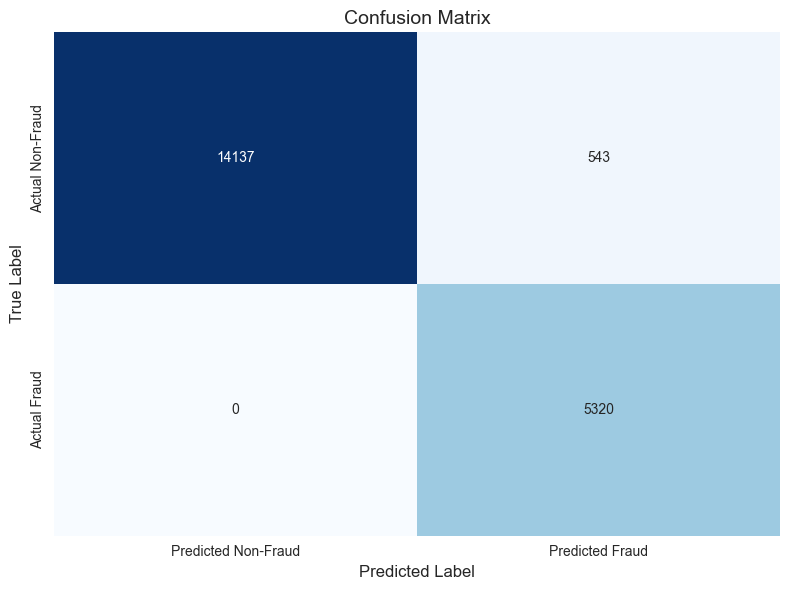


Generating ROC Curve...


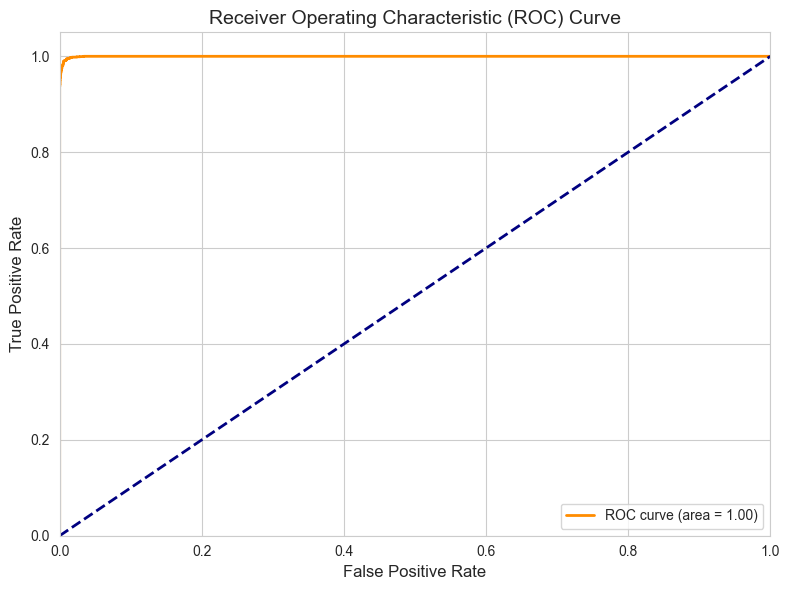


--- Model Building, Training, and Evaluation Complete. ---


In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_train_processed, y_train, X_test_processed, y_test are available from the previous step

print("--- Starting Model Building & Training ---")

# --- 1. Addressing Class Imbalance using SMOTE ---
print("\n1. Applying SMOTE to the training data to address class imbalance...")
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE only to the training data (X_train_processed, y_train)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print(f"Original training data shape: {X_train_processed.shape}, Target distribution: {y_train.value_counts().tolist()}")
print(f"Resampled training data shape: {X_train_resampled.shape}, Target distribution: {y_train_resampled.value_counts().tolist()}")

# --- 2. Model Choice: XGBoost Classifier ---
print("\n2. Initializing and Training XGBoost Classifier...")

# Initialize the XGBoost Classifier
# Using common parameters, can be tuned further for optimal performance
# scale_pos_weight is implicitly handled by SMOTE, but can be set for imbalanced data without SMOTE
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', # For binary classification
    eval_metric='logloss',      # Evaluation metric
    use_label_encoder=False,    # Suppress warning
    n_estimators=100,           # Number of boosting rounds
    learning_rate=0.1,          # Step size shrinkage
    max_depth=5,                # Maximum depth of a tree
    subsample=0.8,              # Subsample ratio of the training instance
    colsample_bytree=0.8,       # Subsample ratio of columns when constructing each tree
    random_state=42,            # For reproducibility
    n_jobs=-1                   # Use all available CPU cores
)

# Train the model on the SMOTE-resampled training data
print("Training the XGBoost model...")
xgb_model.fit(X_train_resampled, y_train_resampled)
print("XGBoost Model Training Complete.")

# --- 3. Model Evaluation (on the original, unseen test_df) ---
print("\n3. Evaluating Model Performance on Test Data...")

# Make predictions on the test set
y_pred = xgb_model.predict(X_test_processed)
y_pred_proba = xgb_model.predict_proba(X_test_processed)[:, 1] # Probabilities for the positive class (fraud)

# Calculate key metrics
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)
roc_auc = auc(roc_curve(y_test, y_pred_proba)[0], roc_curve(y_test, y_pred_proba)[1])

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- Visualizations for Model Evaluation (Slide 9) ---

# Confusion Matrix
print("\nGenerating Confusion Matrix...")
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'],
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# ROC Curve
print("\nGenerating ROC Curve...")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print("\n--- Model Building, Training, and Evaluation Complete. ---")


In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_predict_processed and predict_claim_ids are available from previous steps
# Also assuming xgb_model is trained from the previous step

print("--- Starting Prediction and Submission File Generation ---")

# --- 1. Load the submission file template ---
try:
    submission_df = pd.read_csv("Auto_Insurance_Fraud_Claims_Results_Submission.csv")
    print("Submission file template loaded successfully.")
except Exception as e:
    print(f"Error loading submission file: {e}")
    exit()

# --- Robustly ensure 'claim_id' column exists and is correctly named in submission_df ---
# This addresses the KeyError by explicitly checking and renaming
found_claim_id_col = False
for col in submission_df.columns:
    # Standardize the current column name to check against 'claim_id'
    standardized_col_check = col.lower().replace(' ', '_')
    if 'claim_id' in standardized_col_check:
        submission_df.rename(columns={col: 'claim_id'}, inplace=True)
        found_claim_id_col = True
        break # Found and renamed, no need to check other columns

if not found_claim_id_col:
    print("Error: 'claim_id' column (or a variation) not found in the submission file after standardization attempt. Cannot proceed.")
    exit()

print(f"Columns in submission_df after standardization: {submission_df.columns.tolist()}")


# --- 2. Make Predictions on the predict_df (X_predict_processed) ---
print("\n2. Making predictions on the unlabeled 'predict_df'...")
if 'xgb_model' in locals() and 'X_predict_processed' in locals():
    # Predict the fraud indicator (0 or 1)
    predict_fraud_ind_numeric = xgb_model.predict(X_predict_processed)
    print("Predictions generated.")
else:
    print("Error: xgb_model or X_predict_processed not found. Please ensure previous steps ran successfully.")
    exit()

# --- 3. Convert numerical predictions back to 'Y'/'N' ---
print("\n3. Converting numerical predictions (0/1) to 'N'/'Y'...")
predict_fraud_ind_categorical = np.where(predict_fraud_ind_numeric == 1, 'Y', 'N')
print("Predictions converted to 'Y'/'N' format.")

# --- 4. Fill the 'fraud_ind' column in the submission DataFrame ---
print("\n4. Filling 'fraud_ind' column in the submission file...")

# Create a DataFrame for predictions to merge with submission_df
predictions_df = pd.DataFrame({
    'claim_id': predict_claim_ids, # Use the stored claim_ids for predict_df
    'fraud_ind': predict_fraud_ind_categorical
})

# Ensure 'claim_id' column is consistent (string type) for merging
submission_df['claim_id'] = submission_df['claim_id'].astype(str)
predictions_df['claim_id'] = predictions_df['claim_id'].astype(str)

# Merge with the submission template
final_submission_df = pd.merge(submission_df[['claim_id']], predictions_df, on='claim_id', how='left')

# Ensure the column name is 'Fraud_Ind' as per the submission file format
final_submission_df.rename(columns={'fraud_ind': 'Fraud_Ind'}, inplace=True)

print("Submission file 'Fraud_Ind' column populated.")

# --- 5. Save the final submission file ---
output_filename = "Auto_Insurance_Fraud_Claims_Results_Submission_Predicted.csv"
final_submission_df.to_csv(output_filename, index=False)
print(f"\n5. Final submission file saved as '{output_filename}'")

print("\n--- Prediction and Submission File Generation Complete. ---")

# Display first few rows of the final submission file
print("\nFirst 5 rows of the generated submission file:")
print(final_submission_df.head())


--- Starting Prediction and Submission File Generation ---
Submission file template loaded successfully.
Columns in submission_df after standardization: ['claim_id', 'Fraud_Ind']

2. Making predictions on the unlabeled 'predict_df'...
Predictions generated.

3. Converting numerical predictions (0/1) to 'N'/'Y'...
Predictions converted to 'Y'/'N' format.

4. Filling 'fraud_ind' column in the submission file...
Submission file 'Fraud_Ind' column populated.

5. Final submission file saved as 'Auto_Insurance_Fraud_Claims_Results_Submission_Predicted.csv'

--- Prediction and Submission File Generation Complete. ---

First 5 rows of the generated submission file:
     claim_id Fraud_Ind
0  CC00000001         N
1  CC00000002         N
2  CC00000003         Y
3  CC00000004         N
4  CC00000005         N


--- Starting Prediction and Submission File Generation ---
Submission file template loaded successfully.
Columns in submission_df after standardization: ['claim_id', 'Fraud_Ind']

2. Making predictions on the unlabeled 'predict_df'...
Predictions generated.

3. Converting numerical predictions (0/1) to 'N'/'Y'...
Predictions converted to 'Y'/'N' format.

4. Filling 'fraud_ind' column in the submission file...
Submission file 'Fraud_Ind' column populated.

5. Final submission file saved as 'Auto_Insurance_Fraud_Claims_Results_Submission_Predicted.csv'

--- Prediction and Submission File Generation Complete. ---

First 5 rows of the generated submission file:
     claim_id Fraud_Ind
0  CC00000001         N
1  CC00000002         N
2  CC00000003         Y
3  CC00000004         N
4  CC00000005         N

6. Generating Heatmap of Top Feature Correlations...


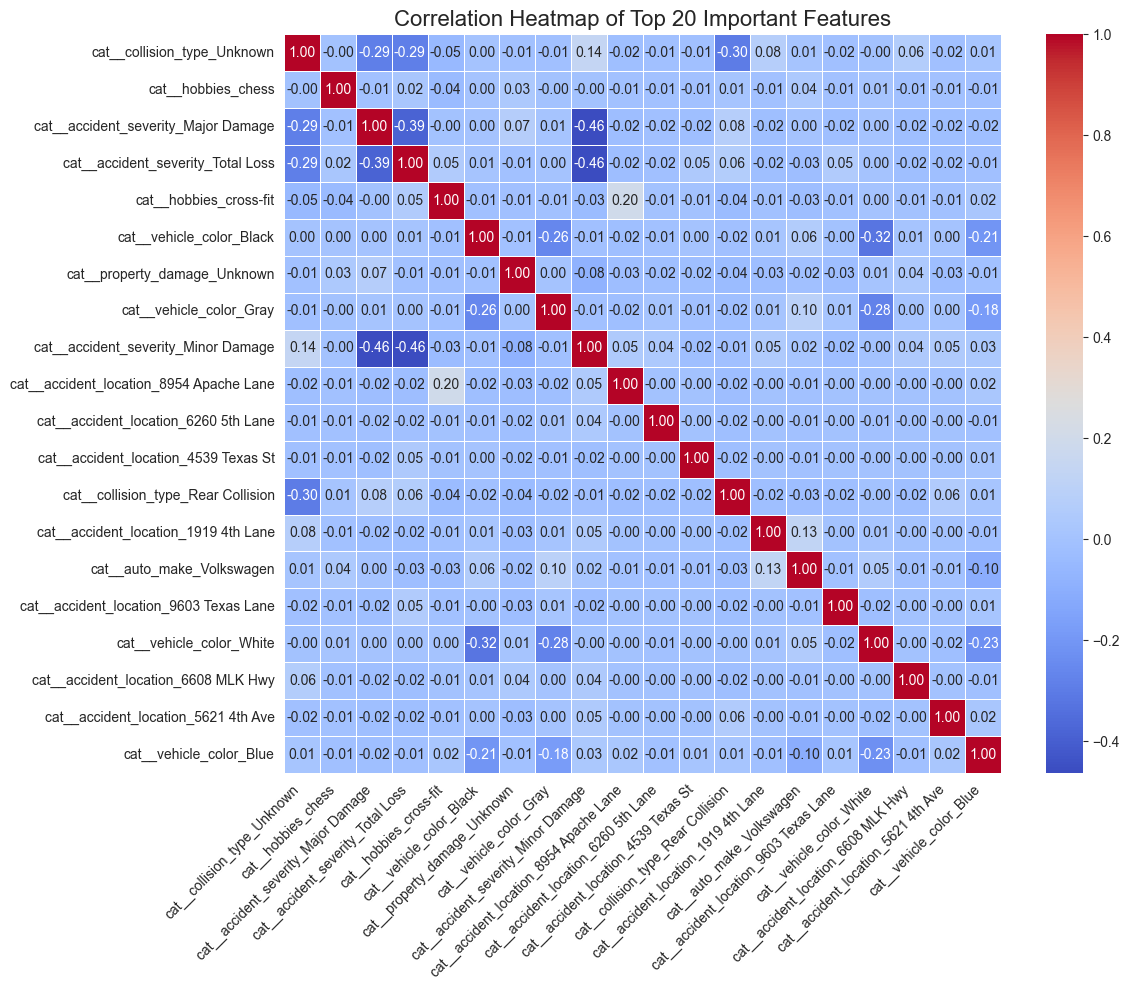


--- Heatmap Generation Complete. ---


In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_predict_processed and predict_claim_ids are available from previous steps
# Also assuming xgb_model is trained from the previous step
# And X_train_processed (or all_data_final) is available for feature names

print("--- Starting Prediction and Submission File Generation ---")

# --- 1. Load the submission file template ---
try:
    submission_df = pd.read_csv("Auto_Insurance_Fraud_Claims_Results_Submission.csv")
    print("Submission file template loaded successfully.")
except Exception as e:
    print(f"Error loading submission file: {e}")
    exit()

# --- Robustly ensure 'claim_id' column exists and is correctly named in submission_df ---
# This addresses the KeyError by explicitly checking and renaming
found_claim_id_col = False
for col in submission_df.columns:
    # Standardize the current column name to check against 'claim_id'
    standardized_col_check = col.lower().replace(' ', '_')
    if 'claim_id' in standardized_col_check:
        submission_df.rename(columns={col: 'claim_id'}, inplace=True)
        found_claim_id_col = True
        break # Found and renamed, no need to check other columns

if not found_claim_id_col:
    print("Error: 'claim_id' column (or a variation) not found in the submission file after standardization attempt. Cannot proceed.")
    exit()

print(f"Columns in submission_df after standardization: {submission_df.columns.tolist()}")


# --- 2. Make Predictions on the predict_df (X_predict_processed) ---
print("\n2. Making predictions on the unlabeled 'predict_df'...")
if 'xgb_model' in locals() and 'X_predict_processed' in locals():
    # Predict the fraud indicator (0 or 1)
    predict_fraud_ind_numeric = xgb_model.predict(X_predict_processed)
    print("Predictions generated.")
else:
    print("Error: xgb_model or X_predict_processed not found. Please ensure previous steps ran successfully.")
    exit()

# --- 3. Convert numerical predictions back to 'Y'/'N' ---
print("\n3. Converting numerical predictions (0/1) to 'N'/'Y'...")
predict_fraud_ind_categorical = np.where(predict_fraud_ind_numeric == 1, 'Y', 'N')
print("Predictions converted to 'Y'/'N' format.")

# --- 4. Fill the 'fraud_ind' column in the submission DataFrame ---
print("\n4. Filling 'fraud_ind' column in the submission file...")

# Create a DataFrame for predictions to merge with submission_df
predictions_df = pd.DataFrame({
    'claim_id': predict_claim_ids, # Use the stored claim_ids for predict_df
    'fraud_ind': predict_fraud_ind_categorical
})

# Ensure 'claim_id' column is consistent (string type) for merging
submission_df['claim_id'] = submission_df['claim_id'].astype(str)
predictions_df['claim_id'] = predictions_df['claim_id'].astype(str)

# Merge with the submission template
final_submission_df = pd.merge(submission_df[['claim_id']], predictions_df, on='claim_id', how='left')

# Ensure the column name is 'Fraud_Ind' as per the submission file format
final_submission_df.rename(columns={'fraud_ind': 'Fraud_Ind'}, inplace=True)

print("Submission file 'Fraud_Ind' column populated.")

# --- 5. Save the final submission file ---
output_filename = "Auto_Insurance_Fraud_Claims_Results_Submission_Predicted.csv"
final_submission_df.to_csv(output_filename, index=False)
print(f"\n5. Final submission file saved as '{output_filename}'")

print("\n--- Prediction and Submission File Generation Complete. ---")

# Display first few rows of the final submission file
print("\nFirst 5 rows of the generated submission file:")
print(final_submission_df.head())


# --- 6. Generate Heatmap of Top Feature Correlations ---
print("\n6. Generating Heatmap of Top Feature Correlations...")

if 'xgb_model' in locals() and 'X_train_processed' in locals():
    # Get feature importances from the trained XGBoost model
    feature_importances = xgb_model.feature_importances_
    feature_names = X_train_processed.columns # Get feature names from the processed training data

    # Create a Series for easier sorting
    importance_series = pd.Series(feature_importances, index=feature_names)

    # Select top N features (e.g., top 20)
    top_n = 20
    top_features = importance_series.nlargest(top_n).index.tolist()

    if len(top_features) > 1: # Ensure there are enough features to plot a heatmap
        # Create a DataFrame with only the top features from the processed training data
        # We need to ensure X_train_processed is available in this scope
        # If not, you might need to re-run the Feature Engineering step or pass it explicitly.
        # Assuming X_train_processed is globally available or passed down.
        top_features_df = X_train_processed[top_features]

        # Calculate the correlation matrix for these top features
        correlation_matrix_top_features = top_features_df.corr()

        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix_top_features, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title(f'Correlation Heatmap of Top {top_n} Important Features', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Not enough top features ({len(top_features)}) to generate a meaningful heatmap.")
else:
    print("Cannot generate heatmap: xgb_model or X_train_processed not found. Please ensure previous steps ran successfully.")

print("\n--- Heatmap Generation Complete. ---")
